In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from collections import deque, namedtuple

# Define map elements
EMPTY = 0
WALL = 1
LAVA = 2
TREASURE = 3
EXIT = 4
START = 5
ENEMY = 6

# Define Colors for Visualization
COLOR_MAP = {
    EMPTY: "white",
    WALL: "brown",
    LAVA: "red",
    TREASURE: "yellow",
    EXIT: "green",
    START: "blue",
    ENEMY: "purple",
}

# Experience replay buffer
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity=5000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append(Experience(state, action, reward, next_state, done))

    def sample(self, batch_size):
        experiences = random.sample(self.buffer, k=batch_size)
        states = torch.stack([torch.tensor(e.state, dtype=torch.float) for e in experiences])
        actions = torch.tensor([e.action for e in experiences])
        rewards = torch.tensor([e.reward for e in experiences], dtype=torch.float)
        next_states = torch.stack([torch.tensor(e.next_state, dtype=torch.float) for e in experiences])
        dones = torch.tensor([e.done for e in experiences], dtype=torch.float)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

class DQNModel(nn.Module):
    """Lightweight Q-Network"""
    def __init__(self, input_dim, output_dim):
        super(DQNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
class DungeonAgent:
    """Agent that learns to generate levels"""
    def __init__(self, state_size, action_size, seed=42):
        self.state_size = state_size
        self.action_size = action_size

        random.seed(seed)
        torch.manual_seed(seed)

        self.qnetwork = DQNModel(state_size, action_size)
        self.optimizer = optim.Adam(self.qnetwork.parameters(), lr=0.001)
        self.memory = ReplayBuffer(5000)

        self.batch_size = 32
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_decay = 0.999995
        self.epsilon_min = 0.000001

    def act(self, state, eval_mode=False):
        """Modified to add some randomness in evaluation mode"""
        if not eval_mode and random.random() < self.epsilon:
            return random.randint(0, self.action_size - 1)

        state = torch.tensor(state, dtype=torch.float).unsqueeze(0)
        with torch.no_grad():
            action_values = self.qnetwork(state)

        # Add slight randomness in evaluation mode
        if eval_mode and random.random() < 0.2:  # 20% chance to explore
            return random.choice(np.arange(self.action_size))

        return torch.argmax(action_values).item()


    def step(self, state, action, reward, next_state, done):
        """Save experience & train"""
        self.memory.push(state, action, reward, next_state, done)
        if len(self.memory) > self.batch_size:
            self.learn(self.memory.sample(self.batch_size))

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        Q_expected = self.qnetwork(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        Q_targets = rewards + (self.gamma * self.qnetwork(next_states).max(1)[0] * (1 - dones))

        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

In [ ]:
class DungeonEnvironment:
    """Environment for RL-based level generation inside a fixed 20x20 board."""
    def __init__(self, difficulty=5):
        self.board_size = 20  # Fixed outer board size
        self.difficulty = difficulty  # Difficulty level (1-10)
        self.width, self.height = self._determine_playable_size()
        self.grid = np.zeros((self.board_size, self.board_size), dtype=np.int8)
        self.max_steps = (self.width * self.height) // 2  # Adjust steps based on size
        self.current_step = 0
        self.element_types = [EMPTY, WALL, LAVA, TREASURE]
        self.start_pos = None
        self.exit_pos = None

        # Compute playable area boundaries
        self.playable_start_x = (self.board_size - self.width) // 2
        self.playable_start_y = (self.board_size - self.height) // 2
        self.playable_end_x = self.playable_start_x + self.width - 1
        self.playable_end_y = self.playable_start_y + self.height - 1

    def _determine_playable_size(self):
        """Determine the playable area based on difficulty (inside 20x20)."""
        if self.difficulty <= 3:  # Easy
            return random.randint(8, 10), random.randint(8, 10)
        elif self.difficulty <= 7:  # Medium
            return random.randint(12, 16), random.randint(12, 16)
        else:  # Hard
            return random.randint(18, 20), random.randint(18, 20)

    def _generate_maze_reference(self):
        """Generate a structured maze inside playable boundaries using Prim's Algorithm."""


        maze_grid = np.ones((self.board_size, self.board_size), dtype=np.int8) * WALL

        # Ensure paths are only inside playable area
        for y in range(self.playable_start_y, self.playable_end_y + 1):
            for x in range(self.playable_start_x, self.playable_end_x + 1):
                maze_grid[y, x] = WALL

        #Choose a random start position inside playable area
        start_x = random.randint(self.playable_start_x + 1, self.playable_end_x - 2)
        start_y = random.randint(self.playable_start_y + 1, self.playable_end_y - 2)
        maze_grid[start_y, start_x] = EMPTY

        #Use Prim’s algorithm to generate the maze
        frontier = [(start_x, start_y)]

        while frontier:
            x, y = frontier.pop(random.randint(0, len(frontier) - 1))  # Pick a random frontier cell

            # Find neighbors two steps away that are still walls
            neighbors = [(x + dx * 2, y + dy * 2) for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]
                        if self.playable_start_x + 1 <= x + dx * 2 <= self.playable_end_x - 1 and
                            self.playable_start_y + 1 <= y + dy * 2 <= self.playable_end_y - 1 and
                            maze_grid[y + dy * 2, x + dx * 2] == WALL]

            if neighbors:
                nx, ny = random.choice(neighbors)
                maze_grid[(ny + y) // 2, (nx + x) // 2] = EMPTY
                maze_grid[ny, nx] = EMPTY
                frontier.append((nx, ny))

        return maze_grid


    def reset(self):
        """Reset dungeon with a structured maze using PCG inside a fixed 20x20 board."""
        self.grid.fill(EMPTY)  #Clear full grid

        # Generate a procedural maze
        self.maze_reference = self._generate_maze_reference()

        # Copy the generated maze into the main grid
        for y in range(self.playable_start_y, self.playable_end_y + 1):
            for x in range(self.playable_start_x, self.playable_end_x + 1):
                self.grid[y, x] = self.maze_reference[y, x]  # Copy pre-generated maze

        # **Ensure playable area is enclosed with walls**
        for y in range(self.board_size):
            for x in range(self.board_size):
                if y == self.playable_start_y or y == self.playable_end_y or x == self.playable_start_x or x == self.playable_end_x:
                    self.grid[y, x] = WALL  # Border walls

        # **Randomly place start and exit inside playable area**
        self.start_pos, self.exit_pos = self._place_start_and_exit()
        self.grid[self.start_pos[1], self.start_pos[0]] = START
        self.grid[self.exit_pos[1], self.exit_pos[0]] = EXIT

        # **Place Enemies based on difficulty level**
        self._place_enemies()

        self.current_step = 0
        return self._get_state()



    def _place_start_and_exit(self):
        """Randomly place start and exit inside playable area."""
        while True:
            sx = random.randint(self.playable_start_x + 1, self.playable_end_x - 1)
            sy = random.randint(self.playable_start_y + 1, self.playable_end_y - 1)
            ex = random.randint(self.playable_start_x + 1, self.playable_end_x - 1)
            ey = random.randint(self.playable_start_y + 1, self.playable_end_y - 1)

            # Ensure they are far apart
            min_distance = max(self.width, self.height) // 2
            if abs(sx - ex) + abs(sy - ey) >= min_distance:
                return (sx, sy), (ex, ey)

    def _calculate_path_complexity(self):
        """Calculate path complexity based on how many paths exist and their lengths."""

        # Perform BFS from start position
        visited = np.zeros((self.board_size, self.board_size), dtype=bool)
        queue = [(self.start_pos, 0)]  # (position, distance)
        visited[self.start_pos[1], self.start_pos[0]] = True
        path_lengths = []

        while queue:
            (x, y), dist = queue.pop(0)

            # If reached exit, store path length
            if (x, y) == self.exit_pos:
                path_lengths.append(dist)
                continue

            # Explore all four directions
            for dx, dy in [(0, -1), (1, 0), (0, 1), (-1, 0)]:
                nx, ny = x + dx, y + dy

                if (0 <= nx < self.board_size and 0 <= ny < self.board_size and
                    not visited[ny, nx] and self.grid[ny, nx] != WALL):
                    visited[ny, nx] = True
                    queue.append(((nx, ny), dist + 1))

        # **Path Complexity Calculation**
        if not path_lengths:
            return 0  # No valid paths = no complexity

        # Complexity = Average path length scaled by grid size
        avg_path_length = sum(path_lengths) / len(path_lengths)
        normalized_complexity = avg_path_length / (self.width + self.height)

        return normalized_complexity  # Returns value between 0-1

    def _place_enemies(self):
        """Place enemies in the level based on difficulty."""
        if self.difficulty < 5:
            return  # No enemies before level 5

        max_enemies = min(4, self.difficulty - 4)  # Max 4 enemies by level 10
        enemy_positions = set()

        while len(enemy_positions) < max_enemies:
            ex = random.randint(self.playable_start_x + 1, self.playable_end_x - 1)
            ey = random.randint(self.playable_start_y + 1, self.playable_end_y - 1)

            if (ex, ey) != self.start_pos and (ex, ey) != self.exit_pos and self.grid[ey, ex] == EMPTY:
                self.grid[ey, ex] = ENEMY
                enemy_positions.add((ex, ey))


    def _generate_maze_reference(self):
        """Generate a simple structured maze reference inside playable boundaries."""
        maze_grid = np.zeros((self.board_size, self.board_size), dtype=np.int8)

        # Place outer walls
        for y in range(self.playable_start_y, self.playable_end_y + 1):
            for x in range(self.playable_start_x, self.playable_end_x + 1):
                if y % 2 == 0 and x % 2 == 0:  # Make a basic grid-like structure
                    maze_grid[y, x] = WALL  # Place walls at even coordinates

        return maze_grid


    def step(self, action):
        """Modify grid based on action, ensuring placement inside playable area."""
        self.current_step += 1
        reward = 0
        done = False

        # **Fixing action mapping to only affect the playable area**
        playable_area_size = self.width * self.height
        position_idx = action % playable_area_size  # Restrict actions to playable cells
        element_type = self.element_types[action % len(self.element_types)]

        # Compute (x, y) inside playable area
        relative_x = position_idx % self.width
        relative_y = position_idx // self.width
        x = self.playable_start_x + relative_x
        y = self.playable_start_y + relative_y

        if x == self.playable_start_x or x == self.playable_end_x or y == self.playable_start_y or y == self.playable_end_y:
            return self._get_state(), 0, False  # No change, no reward

        # Prevent modifying start or exit
        if (x, y) == self.start_pos or (x, y) == self.exit_pos:
            reward += 1  # Small reward for avoiding modification here
        else:
            self.grid[y, x] = element_type  # Place the selected element
            reward += 5  # Base reward for modifying a tile

            if element_type == WALL:
                # Reward walls next to other walls (encourages corridors)
                adjacent_walls = sum(self.grid[y+dy, x+dx] == WALL
                                    for dx, dy in [(0, -1), (1, 0), (0, 1), (-1, 0)]
                                    if 0 <= x+dx < self.board_size and 0 <= y+dy < self.board_size)

                reward += 20 + (adjacent_walls * 5)  # More reward for connected walls

                # Reward balanced maze density (avoid too few or too many walls)
                wall_count = np.sum(self.grid == WALL)
                ideal_wall_percentage = 0.3  # Aim for 30% of the level being walls
                current_wall_ratio = wall_count / (self.width * self.height)

                if 0.25 <= current_wall_ratio <= 0.35:  # Within a good density range
                    reward += 30  # Strong bonus for well-balanced wall placement
                elif current_wall_ratio > 0.4:
                    reward -= 5  # Penalize too many walls
            elif element_type == LAVA:
                reward += 10  # Encourage lava, but less than walls
            elif element_type == TREASURE:
                reward += 15  # Encourage treasure placement

        # **Penalty for too many empty spaces**
        empty_tiles = np.sum(self.grid == EMPTY)
        if empty_tiles > (self.width * self.height) * 0.3:  # More than 30% empty
            reward -= 10  # Discourage empty levels

        # **End of Episode Bonus**
        if self.current_step >= self.max_steps:
            done = True
            path_complexity = self._calculate_path_complexity()
            reward += path_complexity * 30  # Strong reward for complex paths

        return self._get_state(), reward, done



    def _get_state(self):
        return self.grid.flatten().astype(np.float32)

In [ ]:
def train_dungeon_generator(num_episodes=1000, model_path="dungeon_rl_model.pth"):
    """Train a single RL model to generate levels for all difficulties"""
    envs = {d: DungeonEnvironment(d) for d in range(1, 11)}  # One environment per difficulty
    agent = DungeonAgent(state_size=20 * 20, action_size=20 * 20 * len(envs[1].element_types))

    for episode in range(num_episodes):
        difficulty = random.randint(1, 10)  # Randomize difficulty per episode
        env = envs[difficulty]  # Use environment for chosen difficulty
        state = env.reset()
        done = False

        while not done:
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state

        if episode % 100 == 0:
            print(f"Episode {episode}, Epsilon: {agent.epsilon:.3f}, Difficulty: {difficulty}")

    model_path = "/content/drive/MyDrive/FAI/dungeon_rl_model.pth"
    torch.save(agent.qnetwork.state_dict(), model_path)

    return agent, envs



def generate_dungeon_with_model(agent, difficulty):
    """Generate a level using a trained RL model with added randomness"""
    env = DungeonEnvironment(difficulty)
    state = env.reset()
    done = False

    while not done:
        action = agent.act(state, eval_mode=True)

        # 20% chance to randomly explore even in evaluation mode
        if random.random() < 0.2:
            action = random.randint(0, env.width * env.height * len(env.element_types) - 1)

        state, _, done = env.step(action)

    return env.grid


def visualize_dungeon(grid):
    """Display dungeon grid using matplotlib"""
    fig, ax = plt.subplots(figsize=(6, 6))
    for y in range(grid.shape[0]):
        for x in range(grid.shape[1]):
            rect = plt.Rectangle((x, grid.shape[0] - y - 1), 1, 1, facecolor=COLOR_MAP[grid[y, x]], edgecolor='black')
            ax.add_patch(rect)

    ax.set_xlim(0, grid.shape[1])
    ax.set_ylim(0, grid.shape[0])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.title("Generated Dungeon")
    plt.show()

In [ ]:
def load_trained_agent(model_path="/content/drive/MyDrive/FAI/dungeon_rl_model.pth"):
    """Load the trained model weights into a new agent"""
    agent = DungeonAgent(state_size=20*20, action_size=20*20*4)  # Ensure architecture matches
    agent.qnetwork.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    agent.qnetwork.eval()  # Set to evaluation mode
    print(f"Model loaded from: {model_path}")
    return agent

Episode 0, Epsilon: 1.000, Difficulty: 2
Episode 100, Epsilon: 0.946, Difficulty: 4
Episode 200, Epsilon: 0.902, Difficulty: 1
Episode 300, Epsilon: 0.856, Difficulty: 2
Episode 400, Epsilon: 0.812, Difficulty: 3


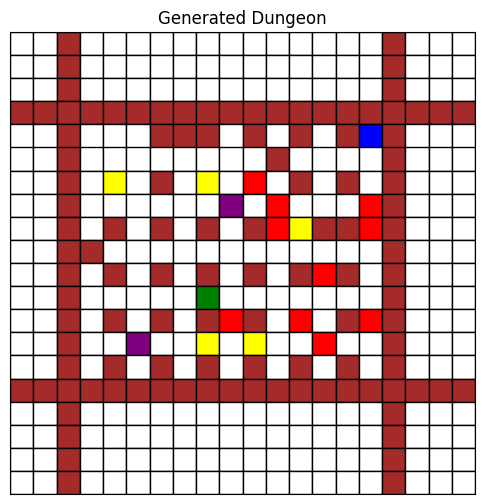

In [ ]:
# Train and Visualize
if __name__ == "__main__":
    trained_agent, trained_envs = train_dungeon_generator(num_episodes=500)
    generated_dungeon = generate_dungeon_with_model(trained_agent, 7)
    visualize_dungeon(generated_dungeon)

Difficulty: 6


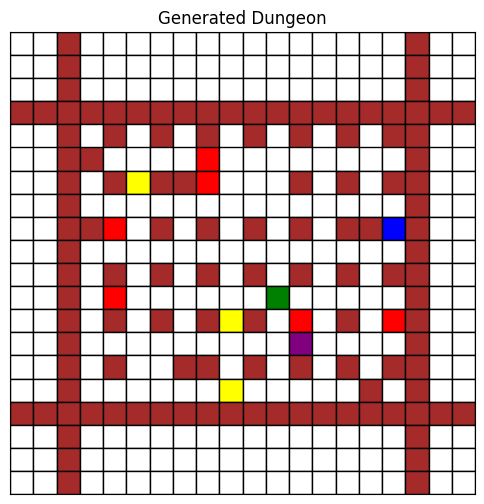

In [ ]:
difficulty = 6
print(f"Difficulty: {difficulty}")
generated_dungeon = generate_dungeon_with_model(trained_agent, difficulty)
visualize_dungeon(generated_dungeon)

Model loaded from: /content/drive/MyDrive/FAI/dungeon_rl_model.pth
Difficulty: 8


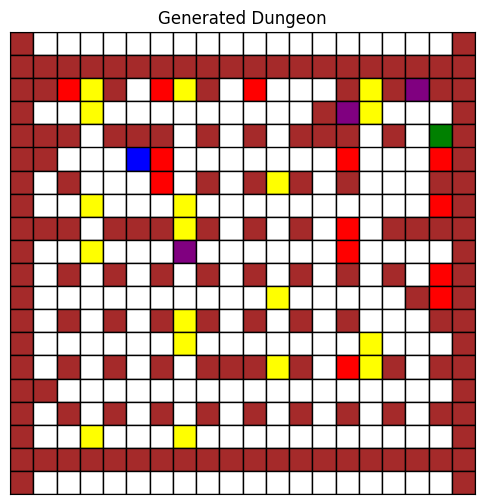

In [ ]:
# Load model before generating dungeons
agent = load_trained_agent("/content/drive/MyDrive/FAI/dungeon_rl_model.pth")  # Ensure same architecture

# Generate dungeon using the loaded model
difficulty = 8
print(f"Difficulty: {difficulty}")
generated_dungeon = generate_dungeon_with_model(agent, difficulty)
visualize_dungeon(generated_dungeon)